# Spatial analysis of beta cell organelle segmentations 

This notebook demonstrates how to generate spatial analysis plots of beta cell organelles as described in the paper:

*Müller, Andreas, et al. "3D FIB-SEM reconstruction of microtubule–organelle interaction in whole primary mouse β cells." Journal of Cell Biology 220.2 (2021).*

    
1. Download the example data (or adapt your own data into the same format)

    - `https://www.dropbox.com/s/vs6bhkrozui7uob/mycell.n5.zip?dl=1`
    - `unzip mycell.n5.zip`

   which should create the datastore `mycell.n5` that contains the masks and distance maps produced by `CellSketch`.

In [1]:
# common imports 
import os
from tqdm.auto import tqdm 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import os
import re
from pathlib import Path

# the cellsketch project will be loaded by a custom data wrapper defined in cell.py 
from cell import Cell

In [2]:
# define input (project) and output folder (where results will be stored)
project = "mycell.n5"
output = "output"

## Helper methods for plotting

This code provides methods for the plots used in the publication outlined above. Feel free to adjust the style settings according to your needs.

In [3]:
cell_color = '#edb380'
text_connected = 'assoc'
text_not_connected = 'not assoc'
color_connected = '#ff7254'
color_not_connected = '#616163'

def histogram(ax_left, ax_right, data, kws):
    ax_left.hist(data, histtype="stepfilled", color=cell_color, weights=np.ones(len(data)) / len(data),
                 **kws)
    # cummulative plot
    ax_right.hist(data, histtype="step", cumulative=True, linestyle="dotted", color="#FF0000",
                  weights=np.ones(len(data)) / len(data), **kws)


def generate_plot_with_percentage(ax):
    ax_right = ax.twinx()
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax_right.yaxis.set_major_formatter(PercentFormatter(1))
    ax_right.tick_params(axis='y', labelcolor="#FF0000")
    ax_right.set_ylim([0, 1])
    return ax_right


def distances_filtered(distance_map, mask_in, masks_out):
    mask = mask_in > 0
    if masks_out is not None:
        for mask_out in masks_out:
            mask = mask & (mask_out == 0)
    return np.array(distance_map[mask])  

def violin_plot(ax, table, column):
    table['dummy'] = 0
    sns.violinplot(y="dummy", x=column, data=table, orient='h', inner=None,
                   color=cell_color, ax=ax)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for violin in ax.collections:
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))
    old_len_collections = len(ax.collections)
    sns.stripplot(y="dummy", x=column, data=table, ax=ax, orient='h', color=cell_color,
                  size=3)
    for dots in ax.collections[old_len_collections:]:
        dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylabel("")
    ax.get_yaxis().set_ticks([])

    
def violin_plot_divided_by_mt_connection(ax, table, column, column_connected):
    table['dummy'] = 0
    sns.violinplot(data=table, x='dummy', y=column, hue=column_connected, split=True,
                   palette=(color_not_connected, color_connected), ax=ax)
    ax.legend(handles= ax.get_legend_handles_labels()[0], 
              loc = (.6,.8),
              labels=[text_not_connected, text_connected], 
              frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel("")
    ax.get_xaxis().set_ticks([])

def histogram_divided_by_mt_connection(ax, table, column, column_connected, kws):
    granules_size_connected = column[table[column_connected] == True]
    granules_size_not_connected = column[table[column_connected] == False]
    num_connected = len(granules_size_connected)
    num_not_connected = len(granules_size_not_connected)
    ax.hist([granules_size_connected, granules_size_not_connected], label=[text_connected, text_not_connected],
            color=[color_connected, color_not_connected],
            weights=[np.ones(num_connected) / num_connected, np.ones(num_not_connected) / num_not_connected],
            **kws)
    ax.legend(loc=(1,1), frameon=False)
    sns.despine()
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
def render_and_save(fig, title):
    fig.suptitle(title)
    plt.tight_layout()
    if output:
        plt.savefig(str(Path(output).joinpath(title.replace(" ", "_") + ".svg")))
    plt.show()
    plt.close(fig)

## Project initialization
This loads the provided CellSketch project location as an N5 project and makes sure the output folder for saving the plots exists.

In [4]:
cell = Cell(project)    
pixel_to_um = cell.file.attrs['pixelToUM']
if output:
    Path(output).mkdir(parents=True, exist_ok=True)
    print("Saving plots to %s" % output)

Saving plots to output


## Filaments
### General attributes
Next, we are plotting some general calculated attributes of the filaments registered in this project.

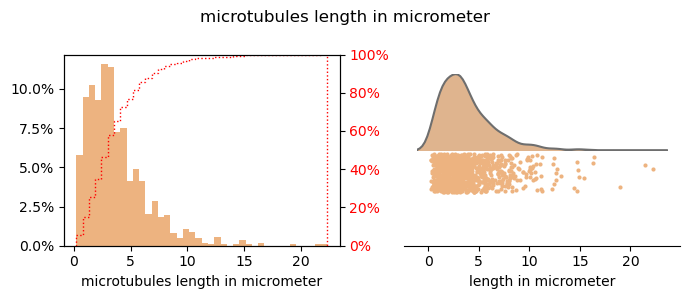

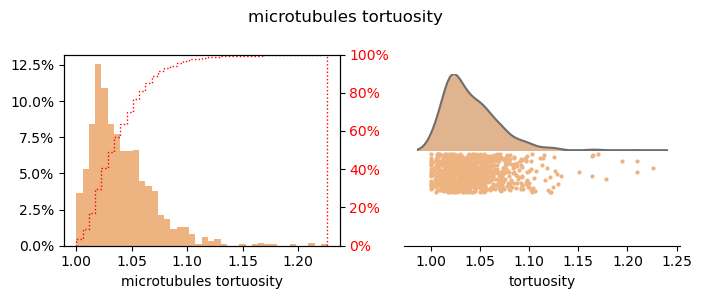

In [5]:
column_names = ['length in micrometer', 'tortuosity']

for filament in cell.get_filaments():
    
    for column_name in column_names:
    
        table_mt_individual = cell.read_individual_table(filament)

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

        # histogram
        ax_right = generate_plot_with_percentage(ax0)
        column = table_mt_individual[column_name]
        histogram(ax0, ax_right, column, kws=dict(bins=40))
        ax0.set_xlabel('%s %s' % (filament, column_name))

        # violin plot
        violin_plot(ax1, table_mt_individual, column)

        render_and_save(fig, '%s %s' % (filament, column_name))

### Filament ends distance to masks in project
Now we are plotting the distance between each mask and the closest of the two ends of each filament.

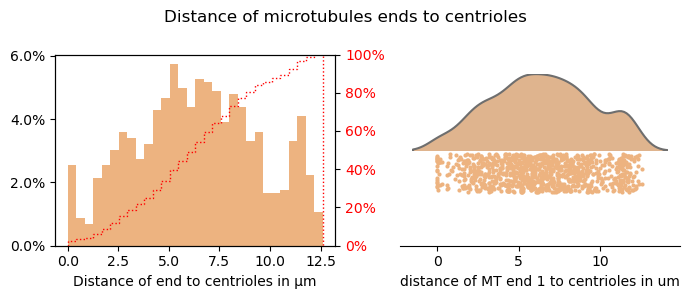

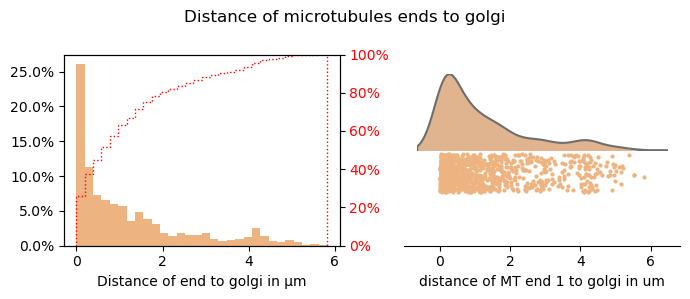

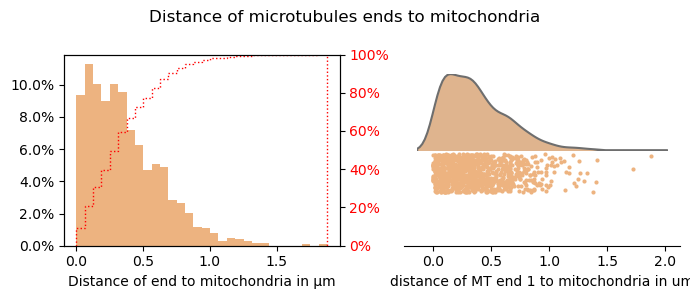

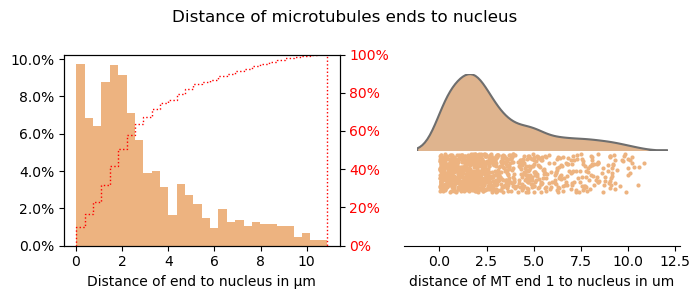

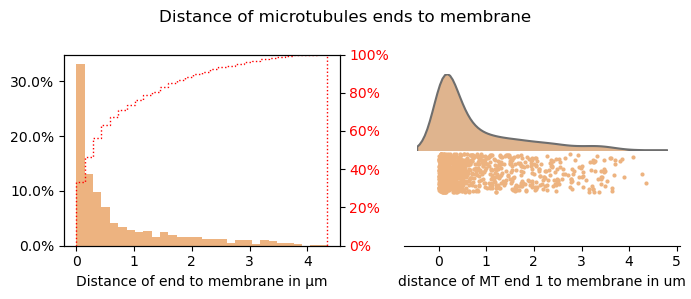

In [6]:
for filament in cell.get_filaments():
    
    table_individual = cell.read_individual_table(filament)
    
    for mask in cell.get_masks() + [cell.get_bounds()]:
        
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

        # histogram
        ax_right = generate_plot_with_percentage(ax0)
        column = table_individual['distance of MT end 1 to ' + mask + ' in um']
        histogram(ax0, ax_right, column, kws=dict(bins=30))
        ax0.set_xlabel('Distance of end to ' + mask + ' in μm')

        # violin plot
        violin_plot(ax1, table_individual, column)

        render_and_save(fig, 'Distance of ' + filament + ' ends to ' + mask)

## Labelmaps
### General attributes (divided by association to filaments)
In this section we are plotting general attributes of all labels of the labelmaps added to this project. The center and right plot divide the labels into two groups - those associated with (connected to) filaments of the project and those who are not associated with / connected to the filaments.

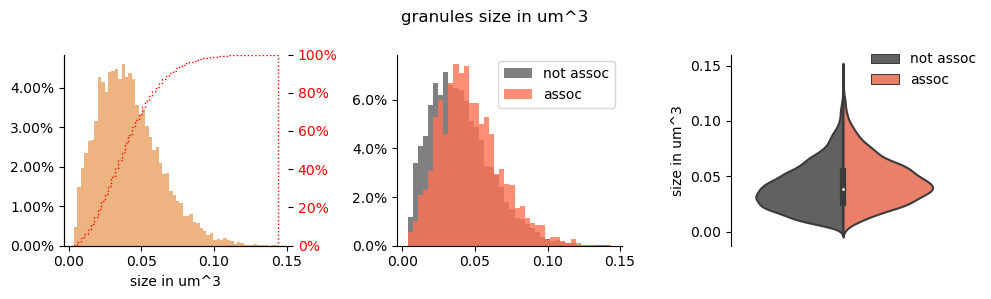

In [7]:
column_names = ['size in um^3', ]

for labelmap in cell.get_labelmaps():
    
    table_individual = cell.read_individual_table(labelmap)
        
    for filament in cell.get_filaments():
        
        for column_name in column_names:

            column_connected = 'connected to ' + filament
            
            fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))

            # histogram
            ax_right = generate_plot_with_percentage(ax0)
            column = table_individual[column_name]
            histogram(ax0, ax_right, column, kws=dict(bins=60))
            ax0.set_xlabel(column_name)

            # histogram comparing granules separated by whether they are connected to MTs or not
            kws = dict(histtype="stepfilled", alpha=0.8, linewidth=2, bins=40)
            histogram_divided_by_mt_connection(ax=ax1, table=table_individual, column=column, column_connected=column_connected, kws=kws)
            ax1.legend()

            # violin plot
            violin_plot_divided_by_mt_connection(ax2, table_individual, column, column_connected)
            render_and_save(fig1, '%s %s' % (labelmap, column_name))

### Distance between labels of labelmaps and masks (divided by association to filaments)
Now we are plotting the distance of all labels of the labelmaps to each mask belonging to the project. The center and right plot divide the labels into two groups - those associated with (connected to) filaments of the project and those who are not associated with / connected to the filaments.

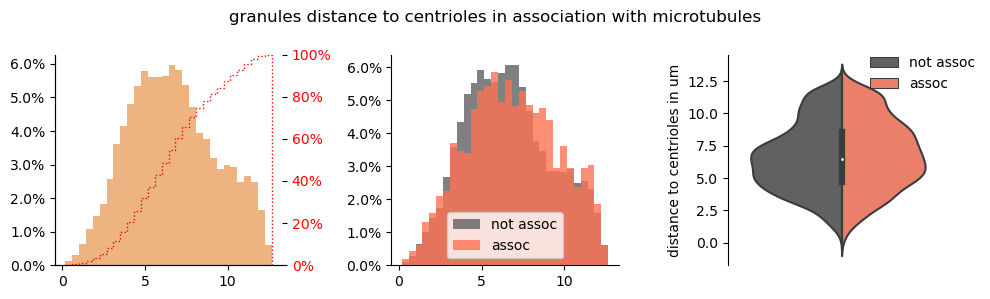

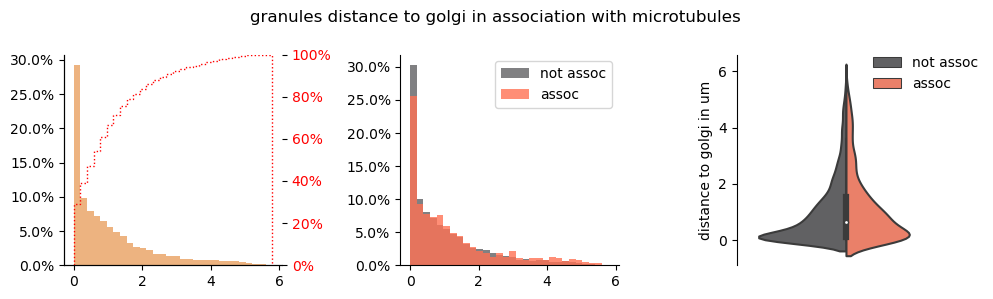

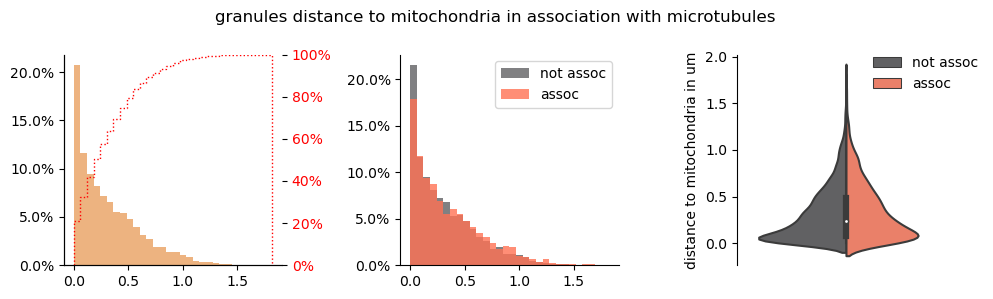

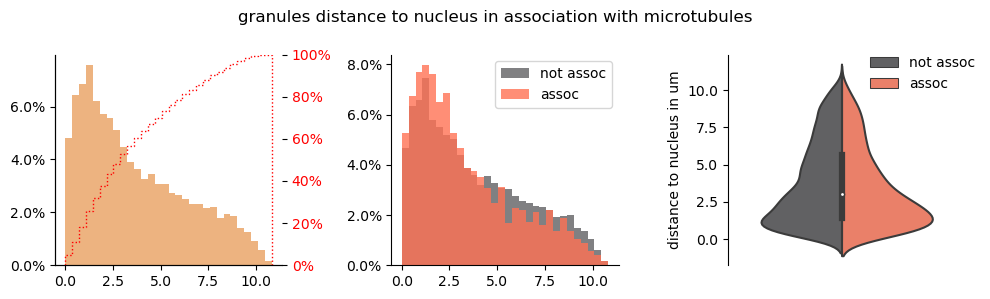

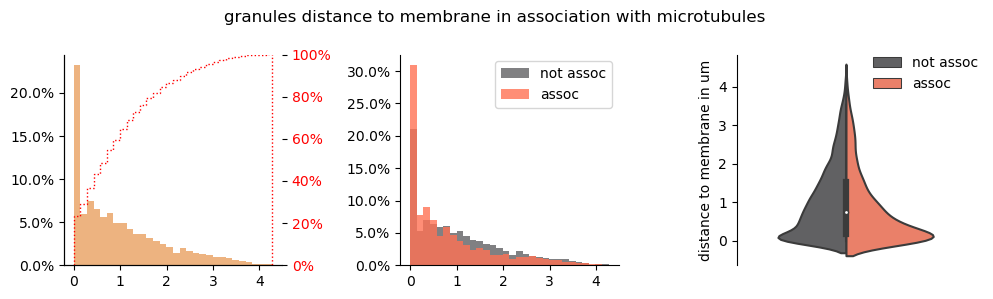

In [8]:
for labelmap in cell.get_labelmaps():
    
    table_individual = cell.read_individual_table(labelmap)
    
    for mask in cell.get_masks() + [cell.get_bounds()]:
        
        for filament in cell.get_filaments():
            
            column_connected = 'connected to ' + filament
        
            # Plot distance to golgi

            column_name = 'distance to ' + mask + ' in um'

            fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))

            # histogram
            ax_right = generate_plot_with_percentage(ax0)
            column = table_individual[column_name]
            histogram(ax0, ax_right, column, kws=dict(bins=30))

            # histogram comparing labels separated by whether they are connected to filaments or not
            kws = dict(histtype="stepfilled", alpha=0.8, linewidth=2, bins=30)
            histogram_divided_by_mt_connection(ax=ax1, table=table_individual, column=column, column_connected=column_connected, kws=kws)
            ax1.legend()

            # violin plot
            violin_plot_divided_by_mt_connection(ax2, table_individual, column, column_connected)

            render_and_save(fig1, '%s distance to %s in association with %s' % (labelmap, mask, filament))

## Volume calculations

This compares the volumetric size of all labelmaps and masks of the project to each other.

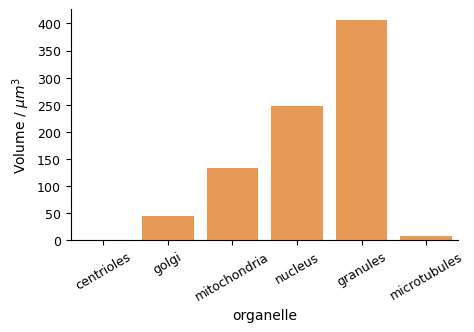

In [9]:
df = cell.compute_volumes()

# plot volumes

figure, ax = plt.subplots(figsize=(5, 3))
# use y="volume_fraction" to plot percentages
sns.barplot(data=df, x="organelle", y="volume", ax=ax, color='C1', alpha=.8)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.tick_params(axis='x', which='major' , rotation=30)
ax.set_ylabel('Volume / $µm^3$')
sns.despine()

## Custom plots example: granules distance to MTs with random distribution reference
This is a more complex example of how to access the data of the CellSketch project for custom plots. Here we plot the distance of the granules labels to the microtubules, adding a reference line to the histogram. The line colored in black is representing how likely it is based on the shape of the cell and the microtubules distrubution to be connected to a microtubule by chance.

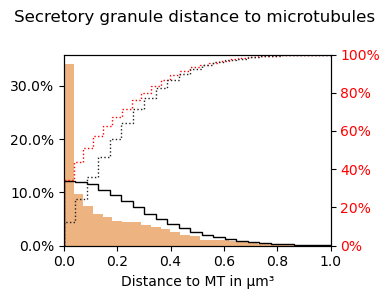

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Read individual and overall granules tables
table_granules_individual = cell.read_individual_table('granules')
table_granules_overall = cell.read_overall_table('granules')

# Get data from table
granules_distance_to_MT = table_granules_individual['distance to microtubules in um']

# Calculate mean radius of granules
mean_volume = table_granules_overall['mean size in micrometer^3'][0]
mean_radius = (3. / (4. * np.pi) * mean_volume) ** (1. / 3.)

# Calculate random distribution data
distance_map = cell.read_distance_map("microtubules")
mask_in = cell.read_volume("membrane")
masks_out = [cell.read_volume("microtubules"), cell.read_volume("nucleus")]
data_random = distances_filtered(distance_map, mask_in, masks_out) * pixel_to_um
data_random -= mean_radius
data_random = data_random[data_random >= 0]


# Plot distance to MT statistics
fig, ax_left = plt.subplots(figsize=(4, 3))
ax_right = generate_plot_with_percentage(ax_left)

# Plot histogram
kws = dict(bins=30)
histogram(ax_left, ax_right, granules_distance_to_MT, kws)

# Plot random distribution
ax_left.hist(data_random, histtype="step", label="random distribution", color='#000000',
             weights=np.ones(len(data_random)) / len(data_random), **kws)
ax_right.hist(data_random, histtype="step", cumulative=True, linestyle="dotted", color="#212122",
              weights=np.ones(len(data_random)) / len(data_random), **kws)

# Set axis limits and labels
ax_left.set_xlim([0, 1])
ax_left.set_xlabel('Distance to MT in μm³')

# Render and save the figure
render_and_save(fig, 'Secretory granule distance to microtubules')